# AI model for training (shark fin) artifacts on GOES-R

[How to Train an Image Classifier in PyTorch and use it to Perform Basic Inference on Single Images](https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5)

[TRAINING A CLASSIFIER](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)


In [1]:
#%load_ext tensorboard
%load_ext tensorboard
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as nr
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import os.path as op
import os
from subprocess import Popen
import tensorboard
import datetime
import sys
import time

# imports
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
nr.seed = 42
data_train_dir = '/scratch/adomakor412/train/'
data_test_dir = '/scratch/adomakor412/test/'
data_val_dir = '/scratch/adomakor412/val/'

In [3]:
# full_fillin = os.listdir('/scratch/adomakor412/color_png_GOES/fillin/')
# nr.shuffle(full_fillin)

# full_sharkfin = os.listdir('/scratch/adomakor412/color_png_GOES/sharkfin/')
# nr.shuffle(full_sharkfin)

# #80% for Test-train of which is broken into 1:2 ratio
# #80% for Test-train of which is broken into 1:2 ratio
# #20% for Validation

# ind_fillin = int(np.floor(len(full_fillin) * 0.8)*(.66))
# ind_fillin_val = int(np.floor(len(full_fillin) * 0.8))
# fillin_train = full_fillin[:ind_fillin]
# fillin_test = full_fillin[ind_fillin:]
# fillin_val = full_fillin[ind_fillin_val:]

# with open('fillintrain.txt', 'w+') as filehandle:
#     filehandle.write('%s\n' % fillin_train)
# with open('fillintest.txt', 'w+') as filehandle:
#     filehandle.write('%s\n' % fillin_test)
# with open('fillinval.txt', 'w+') as filehandle:
#     filehandle.write('%s\n' % fillin_val)

# ind_sharkfin = int(np.floor(len(full_sharkfin) * 0.8)*(.66))
# ind_sharkfin_val = int(np.floor(len(full_sharkfin) * 0.8))
# sharkfin_train = full_sharkfin[:ind_sharkfin]
# sharkfin_test = full_sharkfin[ind_sharkfin:]
# sharkfin_val = full_sharkfin[ind_sharkfin_val:]

# with open('sharkfintrain.txt', 'w+') as filehandle:
#     filehandle.write('%s\n' % sharkfin_train)
# with open('sharkfintest.txt', 'w+') as filehandle:
#     filehandle.write('%s\n' % sharkfin_test)
# with open('sharkfinval.txt', 'w+') as filehandle:
#     filehandle.write('%s\n' % sharkfin_val)


In [5]:
# color_dir = '/scratch/adomakor412/color_png_GOES'

# for path in fillin_train:
#     cmd = [f'cp {color_dir}/fillin/{path} {data_train_dir}/fillin/']
#     pid = Popen(cmd, shell=True)
#     pid.communicate()
    
# for path in sharkfin_train:
#     cmd = [f'cp {color_dir}/sharkfin/{path} {data_train_dir}/sharkfin/']
#     pid = Popen(cmd, shell=True)
#     pid.communicate()
    
# for path in fillin_val:
#     cmd = [f'cp {color_dir}/fillin/{path} {data_val_dir}/fillin/']
#     pid = Popen(cmd, shell=True)
#     pid.communicate()
    
# for path in fillin_test:
#     cmd = [f'cp {color_dir}/fillin/{path} {data_test_dir}/fillin/']
#     pid = Popen(cmd, shell=True)
#     pid.communicate()
    
# for path in sharkfin_test:
#     cmd = [f'cp {color_dir}/sharkfin/{path} {data_test_dir}/sharkfin/']
#     pid = Popen(cmd, shell=True)
#     pid.communicate()
    
# for path in sharkfin_val:
#     cmd = [f'cp {color_dir}/sharkfin/{path} {data_val_dir}/sharkfin/']
#     pid = Popen(cmd, shell=True)
#     pid.communicate()


# Tensorboard command line set up

#### [How to “reset” tensorboard data after killing tensorflow instance](https://stackoverflow.com/questions/34454721/how-to-reset-tensorboard-data-after-killing-tensorflow-instance)

#### [Get started with TensorBoard](https://www.tensorflow.org/tensorboard/get_started)


In [6]:
batch_size = 64

In [7]:
def load_split_train_test(traindir, testdir, valdir):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
    val_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])

    train_data = datasets.ImageFolder(traindir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(testdir,
                    transform=test_transforms)
    val_data = datasets.ImageFolder(valdir,
                    transform=test_transforms)
    
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
    valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    
    myTestData.append(test_data)
    myTrainData.append(train_data)
    myValData.append(val_data)
    
    return trainloader, testloader, valloader

trainloader, testloader, valloader = load_split_train_test(data_train_dir,
                                                           data_test_dir, 
                                                           data_val_dir)

print(trainloader.dataset.classes)

['fillin', 'sharkfin']


In [17]:
myTestData[0]

Dataset ImageFolder
    Number of datapoints: 1303
    Root location: /scratch/adomakor412/test/
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [18]:
myTrainData

[Dataset ImageFolder
     Number of datapoints: 1455
     Root location: /scratch/adomakor412/train/
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=PIL.Image.BILINEAR)
                ToTensor()
            )]

In [19]:
myValData

[Dataset ImageFolder
     Number of datapoints: 553
     Root location: /scratch/adomakor412/val/
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=PIL.Image.BILINEAR)
                ToTensor()
            )]

In [20]:
# with open('fillintrain.txt', 'r') as filehandle:
#     for imgPath in filehandle:
#         filehandle.write('%s\n' % imgPath)
       
# with open('fillintest.txt', 'r') as filehandle:
#     for imgPath in MyTestData:
#         filehandle.write('%s\n' % imgPath)
        
# with open('fillinval.txt', 'r') as filehandle:
#     for imgPath in MyValData:
#         filehandle.write('%s\n' % imgPath)

# with open('sharkfintrain.txt', 'r') as filehandle:
#     for imgPath in MyTrainData:
#         filehandle.write('%s\n' % imgPath)
      
# with open('sharkfintest.txt', 'r') as filehandle:
#     for imgPath in MyTestData:
#         filehandle.write('%s\n' % imgPath)
        
# with open('sharkfinval.txt', 'r') as filehandle:
#     for imgPath in MyValData:
#         filehandle.write('%s\n' % imgPath)

In [21]:
for data in trainloader.dataset:
    print(data[0].shape, data[1])
    break

torch.Size([3, 224, 224]) 0


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True)
# PATH = 'ResnetPretrained.pth'
# model = torch.load(PATH)
print(model)
torch.save(model, 'ResnetPretrained.pth')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
epochs = 1#1
steps = 0
running_loss = 0
print_every = 1#10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        print(steps)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print('REACHED RUNNING LOSS')
        if steps % print_every == 0:
            print('I am working')
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
#torch.save(model, 'aerialmodel.pth')

1
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 2.216.. Test loss: 1.105.. Test accuracy: 0.911
2
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 2.120.. Test accuracy: 0.911
3
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 3.085.. Test accuracy: 0.911
4
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 4.023.. Test accuracy: 0.911
5
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 4.910.. Test accuracy: 0.911
6
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 5.817.. Test accuracy: 0.911
7
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 6.708.. Test accuracy: 0.911
8
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 7.577.. Test accuracy: 0.911
9
REACHED RUNNING LOSS
I am working
Epoch 1/1.. Train loss: 0.000.. Test loss: 8.463.. Test accuracy: 0.911
10
REACHED RUNNING LOSS
I am

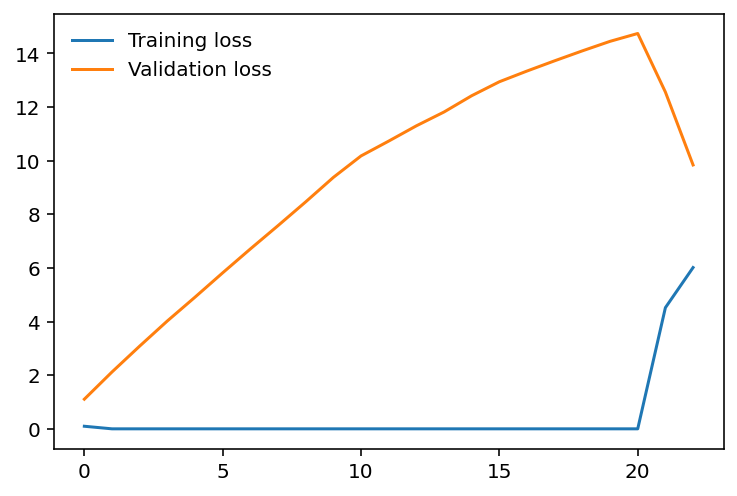

In [27]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

#### Took 1 hour to train. Dataset has 100 sharkfins and 889 fillins. Together that is 989 samples. The train to test split is 80% to 20%. Average test accuracy is over 90%!

In [ ]:
epochs = 10#1
steps = 0
running_loss = 0
print_every = 1#10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        print(steps)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print('REACHED RUNNING LOSS')
        if steps % print_every == 0:
            print('I am working')
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, f'Epoch{epoch}Resnet50Pretrained.pth')

1
REACHED RUNNING LOSS
I am working
Epoch 1/10.. Train loss: 0.000.. Test loss: 7.417.. Test accuracy: 0.911
2
REACHED RUNNING LOSS
I am working
Epoch 1/10.. Train loss: 0.000.. Test loss: 5.406.. Test accuracy: 0.911
3
REACHED RUNNING LOSS
I am working
Epoch 1/10.. Train loss: 0.000.. Test loss: 3.766.. Test accuracy: 0.911
4
REACHED RUNNING LOSS
I am working
Epoch 1/10.. Train loss: 0.000.. Test loss: 2.412.. Test accuracy: 0.911
5
REACHED RUNNING LOSS
I am working
Epoch 1/10.. Train loss: 0.000.. Test loss: 1.298.. Test accuracy: 0.911
6
REACHED RUNNING LOSS
I am working
Epoch 1/10.. Train loss: 0.000.. Test loss: 0.364.. Test accuracy: 0.911
7
REACHED RUNNING LOSS
I am working
Epoch 1/10.. Train loss: 0.058.. Test loss: 3.248.. Test accuracy: 0.089
8
REACHED RUNNING LOSS
I am working
Epoch 1/10.. Train loss: 3.508.. Test loss: 1.340.. Test accuracy: 0.089
9
REACHED RUNNING LOSS
I am working
Epoch 1/10.. Train loss: 1.430.. Test loss: 0.450.. Test accuracy: 0.911
10
REACHED RUNNING 

REACHED RUNNING LOSS
I am working
Epoch 4/10.. Train loss: 0.142.. Test loss: 0.311.. Test accuracy: 0.911
77
REACHED RUNNING LOSS
I am working
Epoch 4/10.. Train loss: 0.168.. Test loss: 0.311.. Test accuracy: 0.911
78
REACHED RUNNING LOSS
I am working
Epoch 4/10.. Train loss: 0.148.. Test loss: 0.310.. Test accuracy: 0.911
79
REACHED RUNNING LOSS
I am working
Epoch 4/10.. Train loss: 0.151.. Test loss: 0.308.. Test accuracy: 0.911
80
REACHED RUNNING LOSS
I am working
Epoch 4/10.. Train loss: 0.123.. Test loss: 0.305.. Test accuracy: 0.911
81
REACHED RUNNING LOSS
I am working
Epoch 4/10.. Train loss: 0.128.. Test loss: 0.302.. Test accuracy: 0.911
82
REACHED RUNNING LOSS
I am working
Epoch 4/10.. Train loss: 0.117.. Test loss: 0.301.. Test accuracy: 0.911
83
REACHED RUNNING LOSS
I am working
Epoch 4/10.. Train loss: 0.109.. Test loss: 0.301.. Test accuracy: 0.911
84
REACHED RUNNING LOSS
I am working
Epoch 4/10.. Train loss: 0.080.. Test loss: 0.304.. Test accuracy: 0.911
85
REACHED RU

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

trainset = trainloader
testset = testloader

classes = trainloader.dataset.classes

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys", vmin=180,vmax=300)
        plt.grid(None) 
        plt.axis('off')
        
    else:
        #plt.imshow(np.transpose(npimg, (1, 2, 0)), vmin=180,vmax=300)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.grid(None) 
        plt.axis('off')

In [ ]:
class Net(nn.Module):
    def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 2)

        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64*9*9, 1024)
        self.fc2 = nn.Linear(1024, 7)

    def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)

        #x = x.view(-1, 64)
        #x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        #x = self.fc2(x)
        return x


net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
writer = SummaryWriter(f'logs/log{time.time()}')

In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid)#, one_channel=True)

# write to tensorboard
# writer.add_image('four_fashion_mnist_images', img_grid)
try:
    writer.flush()
except:
    pass
writer.add_image(f'log/GOES_images{time.time()}', img_grid)

In [ ]:
writer.add_graph(net, images)
writer.close()

In [ ]:
def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    #print('OUTPUT\n\n', output)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    #print('PREDICTION \n\n', preds)
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(batch_size):
        ax = fig.add_subplot(1, batch_size, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [ ]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times
    
    if len(list(enumerate(trainloader, 0))) < 10:
            print('Batch size too small (<10) for PR-curve')
            
    for i, data in enumerate(trainloader, 0):
        
        print (data)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:    # every 1000 mini-batches...
#         if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
        
print('Finished Training')

In [ ]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)